# Triangulation of Kon Tum Mw 5.0 28/07/2024

In [1]:
%config InlineBackend.figure_format = 'retina'

Download origin data

In [2]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# Initialize the client for ISC
isc = Client("ISC")

# Request event information
event = isc.get_events(eventid="641665444")[0]

# Print the event information
print(event)

Event:	2024-07-28T04:35:13.660000Z | +14.780, +108.173 | 5.54 mB

	            resource_id: ResourceIdentifier(id="smi:ISC/evid=641665444")
	             event_type: 'earthquake'
	   event_type_certainty: 'known'
	          creation_info: CreationInfo(agency_id='ISC', author='ISC')
	    preferred_origin_id: ResourceIdentifier(id="smi:ISC/origid=636774696")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:ISC/magid=644867575")
	                   ---------
	     event_descriptions: 1 Elements
	               comments: 1 Elements
	                origins: 1 Elements
	             magnitudes: 4 Elements


In [3]:
## download all available data using mass_downloader
from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader

# Get the origin time, latitude, and longitude of the Kon Tum event
origin_time = event.preferred_origin().time
origin_lat = event.preferred_origin().latitude
origin_lon = event.preferred_origin().longitude

# Circular domain around the epicenter. This will download all data between
# 70 and 90 degrees distance from the epicenter. This module also offers
# rectangular and global domains. More complex domains can be defined by
# inheriting from the Domain class.
domain = CircularDomain(origin_lat, origin_lon, minradius=0.0, maxradius=15.0)

restrictions = Restrictions(
    # Get data from 5 minutes before the event to one hour after the
    # event. This defines the temporal bounds of the waveform data.
    starttime=origin_time - 1 * 60,
    endtime=origin_time + 10 * 60,
    # You might not want to deal with gaps in the data. If this setting is
    # True, any trace with a gap/overlap will be discarded.
    reject_channels_with_gaps=True,
    # And you might only want waveforms that have data for at least 95 % of
    # the requested time span. Any trace that is shorter than 95 % of the
    # desired total duration will be discarded.
    minimum_length=0.95,
    # No two stations should be closer than 10 km to each other. This is
    # useful to for example filter out stations that are part of different
    # networks but at the same physical station. Settings this option to
    # zero or None will disable that filtering.
    minimum_interstation_distance_in_m=150E3,
    # Only HH or BH channels. If a station has HH channels, those will be
    # downloaded, otherwise the BH. Nothing will be downloaded if it has
    # neither. You can add more/less patterns if you like.
    channel_priorities=["BH[ZNE12XY]", "HH[ZNE]"],
    # Location codes are arbitrary and there is no rule as to which
    # location is best. Same logic as for the previous setting.
    location_priorities=["", "00", "10"])

# No specified providers will result in all known ones being queried.
mdl = MassDownloader(providers=['IRIS'])
# The data will be downloaded to the ``./waveforms/`` and ``./stations/``
# folders with automatically chosen file names.
mdl.download(domain, restrictions, mseed_storage="waveforms",
             stationxml_storage="stations")

[2025-03-15 22:51:27,057] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2025-03-15 22:51:27,736] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2025-03-15 22:51:27,738] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2025-03-15 22:51:27,738] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2025-03-15 22:51:35,979] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (8.24 seconds)
[2025-03-15 22:51:36,015] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 37 stations (111 channels).
[2025-03-15 22:51:36,019] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 27 stations.
[2025-03-15 22:51:36,022] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 49 time intervals/channels before downloading: EXI

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7f79ccfffb90>}

Next, we plot the map of all stations registering data of this event.

In [4]:
# read station metadata
from obspy import read_inventory, Inventory
from pathlib import Path

inv = Inventory()
for file in Path("stations").glob("*.xml"):
    inv += read_inventory(str(file))

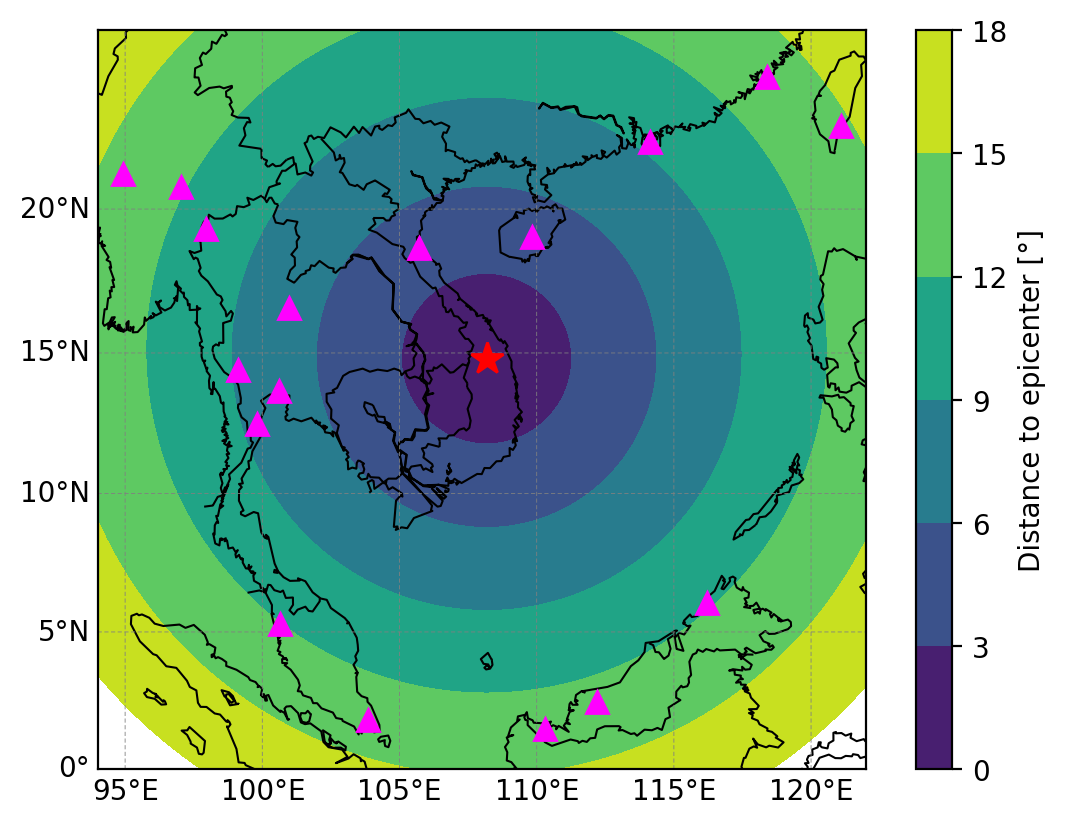

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26,
            llcrnrlon=94, urcrnrlon=122, resolution='l')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the epicenter
m.plot(origin_lon, origin_lat, 'r*', markersize=12, label='Epicenter', latlon=True)

# plot the station locations
for network in inv:
    for station in network:
        lon = station.longitude
        lat = station.latitude
        m.plot(lon, lat, '^', c='magenta', markersize=8, latlon=True)

# plot distance contours to the epicenter
from obspy.geodetics import locations2degrees
x = np.linspace(m.xmin, m.xmax, 300)
y = np.linspace(m.ymin, m.ymax, 300)
mlon, mlat = m(*np.meshgrid(x, y), inverse=True)
dist = locations2degrees(origin_lat, origin_lon, mlat, mlon)
mapple = m.contourf(mlon, mlat, dist, levels=range(0, 19, 3), latlon=True, cmap='viridis')

# add a colorbar
plt.colorbar(mapple, label='Distance to epicenter [°]')

# show the plot
plt.show()

In [6]:
from obspy import read, Stream

dstream = Stream()
for file in Path("waveforms").glob("*.mseed"):
    dstream += read(str(file))
dstream = dstream.select(component='Z')

dstream.filter('highpass', freq=0.1, corners=2, zerophase=False)
dstream = dstream.trim(starttime=origin_time, endtime=origin_time + 600)

In [7]:
## calculate station distances
for tr in dstream:
    tmp = inv.select(station=tr.stats.station, network=tr.stats.network)
    stla = tmp[0][0].latitude
    stlo = tmp[0][0].longitude
    tr.data /= np.max(np.abs(tr.data))
    tr.stats.distance = locations2degrees(origin_lat, origin_lon, stla, stlo) * 111.1195e3
    mask = np.arange(tr.stats.npts) * tr.stats.delta < 60
    tr.stats.noise_level = np.std(tr.data[mask])
dstream_good = Stream([tr for tr in dstream if tr.stats.noise_level < .15])

In [8]:
from obspy.taup import TauPyModel
taup_model = TauPyModel(model="ak135")

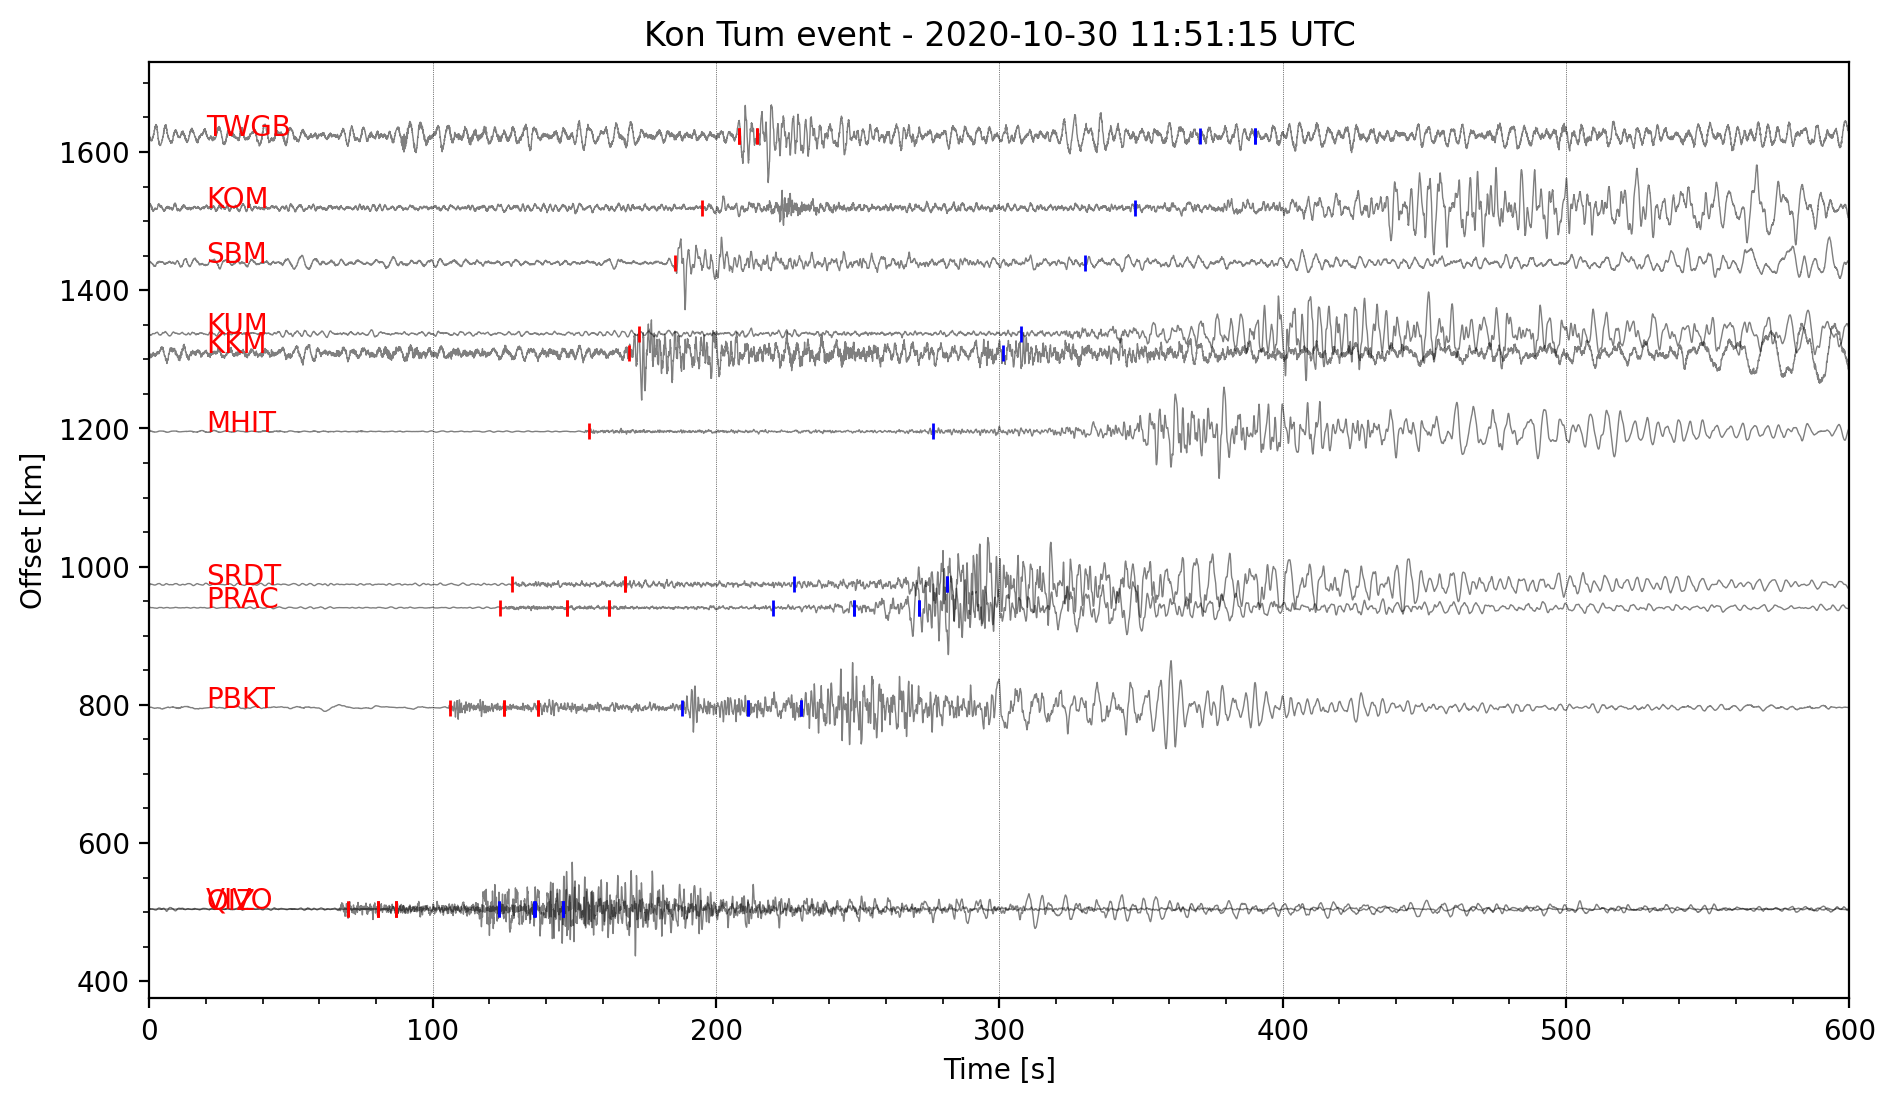

In [9]:
fig = plt.figure(figsize=(10, 6))

dstream_good.plot(type='section', orientation='horizontal', norm_method='trace',
            recordstart=0, recordlength=600, time_down=False, fig=fig,
            linewidth=0.5, grid_linewidth=0.25, size=(800, 600))
ax = fig.gca()
ax.set_title('Kon Tum event - 2020-10-30 11:51:15 UTC')
for tr in dstream_good:
    dist_in_km = tr.stats.distance / 1e3
    ax.text(20, dist_in_km, tr.stats.station, color='r')

    arvs = taup_model.get_travel_times(source_depth_in_km=0, distance_in_degree = dist_in_km/111.1195,
                                    phase_list=['P', 'S'])
    for arr in arvs:
        marker = '|r' if arr.name == 'P' else '|b'
        ax.plot(arr.time, dist_in_km, marker, linewidth=0.5)

plt.show()

Build the travel time curves of P and S wave for interpolation

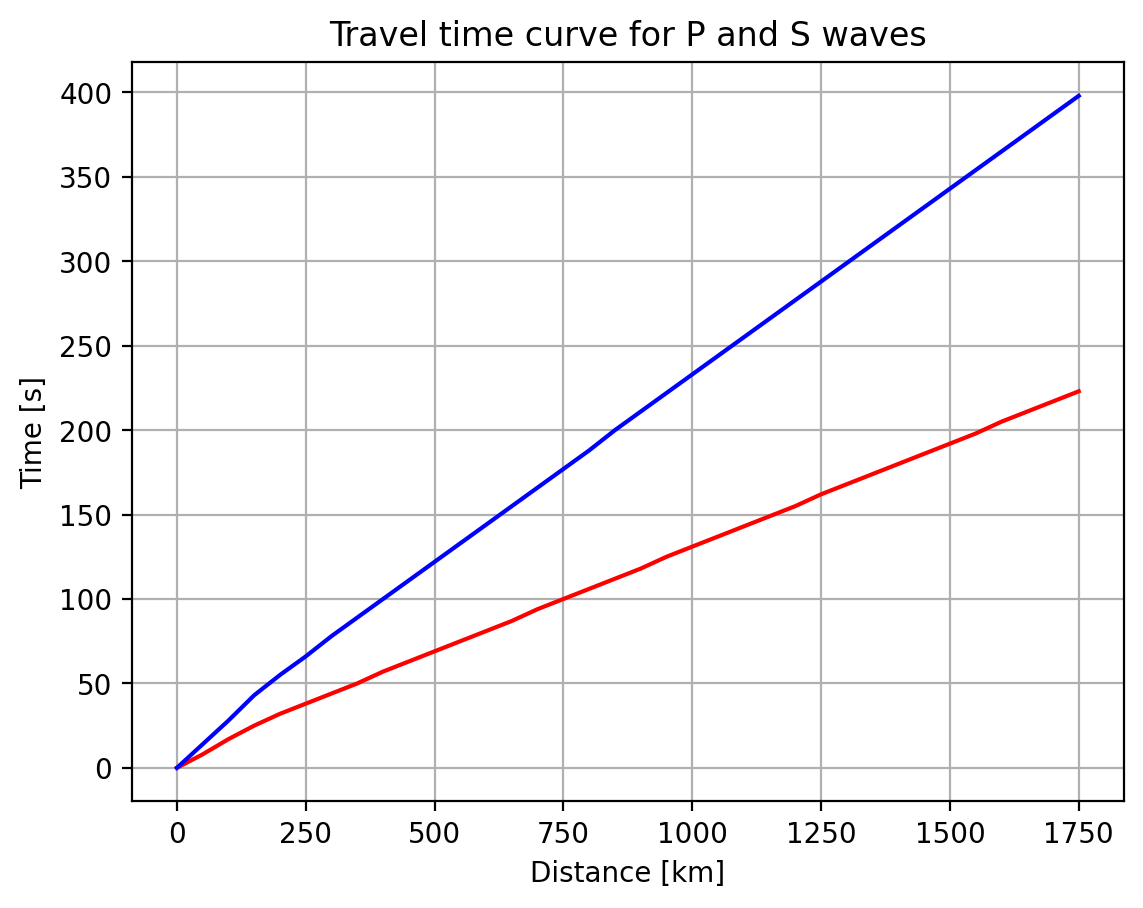

In [10]:
from scipy.interpolate import interp1d

## build the travel time curve for the P and S waves and plot it 
fig, ax = plt.subplots()
dist = np.arange(0, 1800, 50)
time_p = np.zeros_like(dist)
time_s = np.zeros_like(dist)

for i, d in enumerate(dist):
    arvs = taup_model.get_travel_times(source_depth_in_km=0, distance_in_degree = d/111.1195, phase_list=['P'])
    time_p[i] = arvs[0].time
    arvs = taup_model.get_travel_times(source_depth_in_km=0, distance_in_degree = d/111.1195, phase_list=['S'])
    time_s[i] = arvs[0].time

dtime_to_dist = interp1d(time_s-time_p, dist)

ax.plot(dist, time_p, 'r', label='P wave')
ax.plot(dist, time_s, 'b', label='S wave')
ax.set_title('Travel time curve for P and S waves')
ax.set(ylabel='Time [s]', xlabel='Distance [km]')
ax.grid(True)
plt.show()

In [11]:
picks = {}

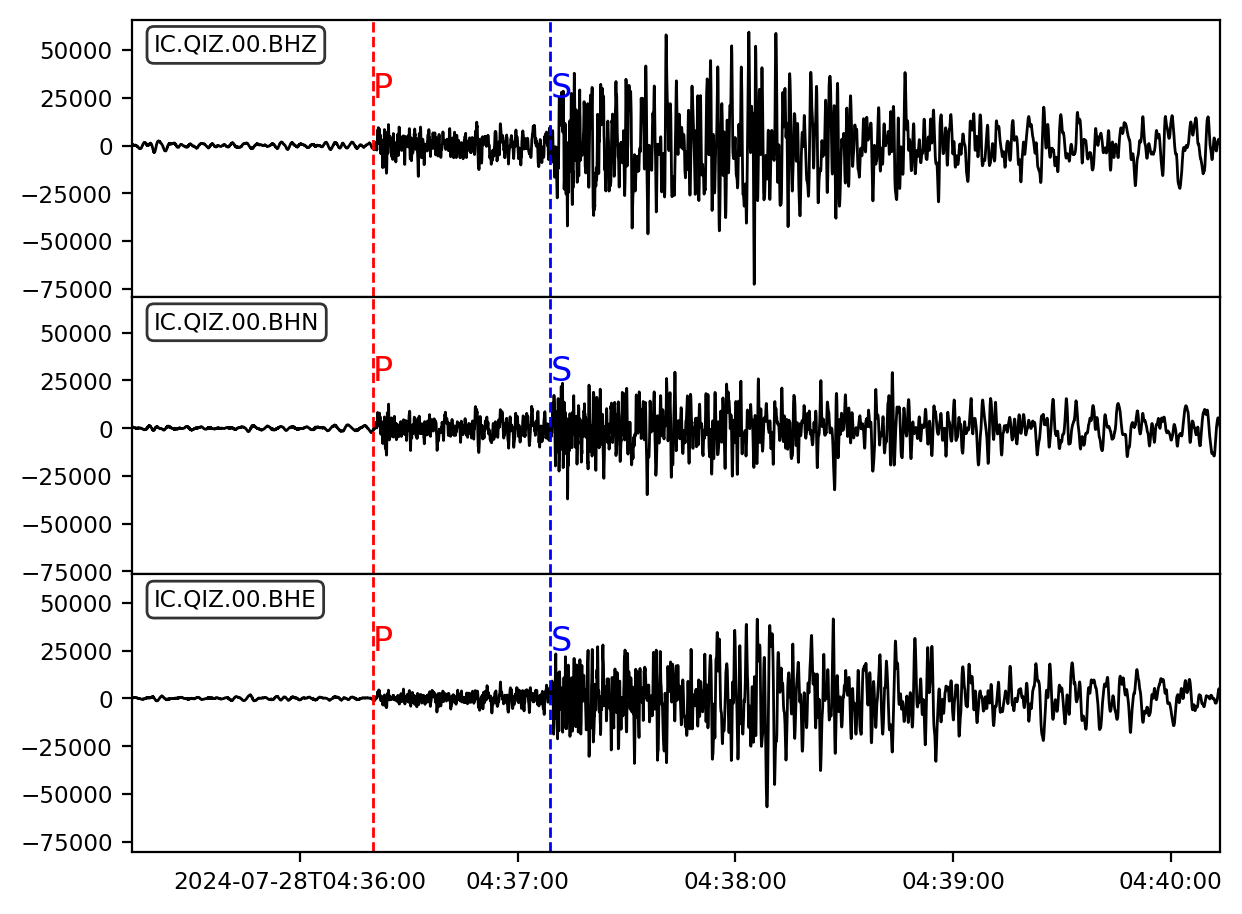

In [12]:
import matplotlib.dates as mdates
from datetime import datetime

fig1 = plt.figure()
st = Stream()
for file in Path("waveforms").glob("*QIZ*.mseed"):
    st += read(str(file))
st.filter('highpass', freq=0.1, corners=2, zerophase=False)
st = st.trim(starttime=origin_time, endtime=origin_time + 300)
st.rotate(method='->ZNE', inventory=inv)
st.plot(fig=fig1)

p_arr = datetime(2024,7,28,4,36,20)
s_arr = datetime(2024,7,28,4,37,9)

tmp = inv.select(station='QIZ')[0][0]
picks['QIZ'] = {'lat': tmp.latitude, 'lon': tmp.longitude, 
    'p_arr': p_arr, 's_arr': s_arr,
    'dist': dtime_to_dist(UTCDateTime(s_arr) - UTCDateTime(p_arr))}

## plot the P and S arrival times
for ax in fig1.axes:
    ax.axvline(p_arr, color='r', linestyle='--', linewidth=1)
    ax.text(p_arr, 2.5e4, 'P', color='r', fontsize=12)
    ax.axvline(s_arr, color='b', linestyle='--', linewidth=1)
    ax.text(s_arr, 2.5e4, 'S', color='b', fontsize=12)
fig.axes[0].xaxis.set_minor_locator(mdates.SecondLocator(interval=10))

plt.show()

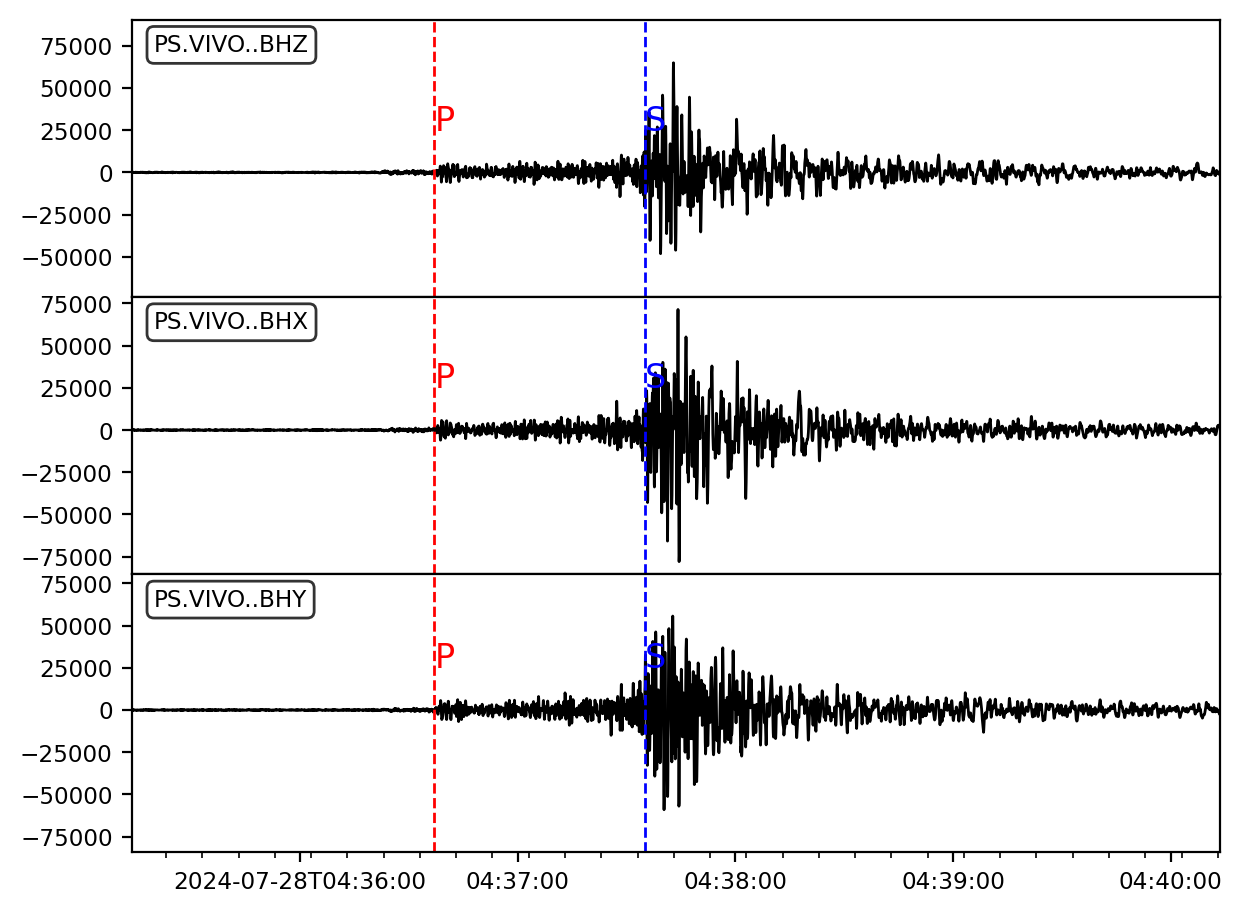

In [13]:
fig = plt.figure()
st = Stream()
for file in Path("waveforms").glob("*VIVO*.mseed"):
    st += read(str(file))
st.filter('highpass', freq=0.1, corners=2, zerophase=False)
st = st.trim(starttime=origin_time, endtime=origin_time + 300)
st.rotate(method='->ZNE', inventory=inv)
st.plot(fig=fig)

p_arr = datetime(2024,7,28,4,36,37)
s_arr = datetime(2024,7,28,4,37,35)

tmp = inv.select(station='VIVO')[0][0]
picks['VIVO'] = {'lat': tmp.latitude, 'lon': tmp.longitude, 
    'p_arr': p_arr, 's_arr': s_arr,
    'dist': dtime_to_dist(UTCDateTime(s_arr) - UTCDateTime(p_arr))}
    
## plot the P and S arrival times
for ax in fig.axes:
    ax.axvline(p_arr, color='r', linestyle='--', linewidth=1)
    ax.text(p_arr, 2.5e4, 'P', color='r', fontsize=12)
    ax.axvline(s_arr, color='b', linestyle='--', linewidth=1)
    ax.text(s_arr, 2.5e4, 'S', color='b', fontsize=12)

fig.axes[0].xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
plt.show()

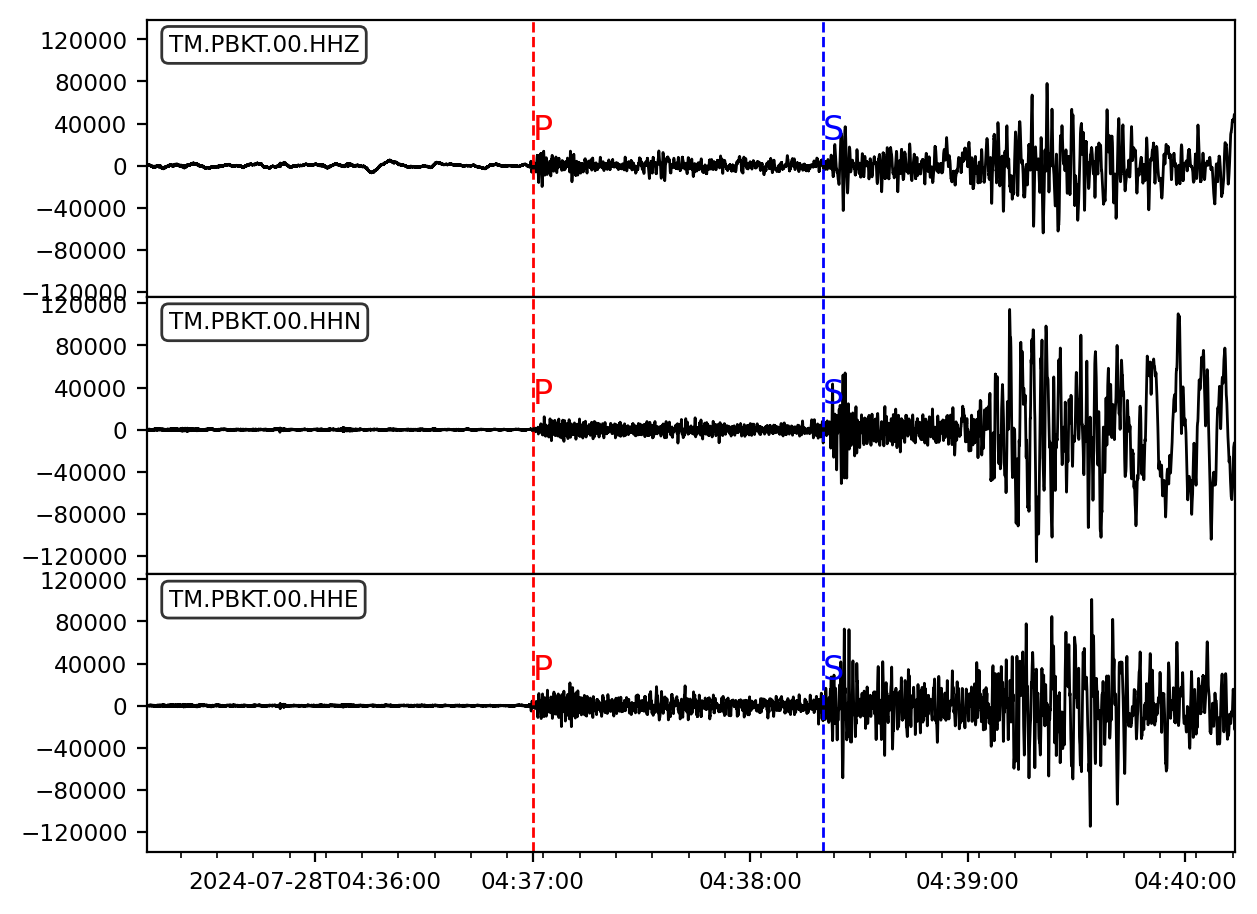

In [14]:
fig = plt.figure()
st = Stream()
for file in Path("waveforms").glob("*PBKT*.mseed"):
    st += read(str(file))
st.filter('highpass', freq=0.1, corners=2, zerophase=False)
st = st.trim(starttime=origin_time, endtime=origin_time + 300)
st.rotate(method='->ZNE', inventory=inv)
st.plot(fig=fig)

p_arr = datetime(2024,7,28,4,37,0)
s_arr = datetime(2024,7,28,4,38,20)

tmp = inv.select(station='PBKT')[0][0]
picks['PBKT'] = {'lat': tmp.latitude, 'lon': tmp.longitude, 
    'p_arr': p_arr, 's_arr': s_arr,
    'dist': dtime_to_dist(UTCDateTime(s_arr) - UTCDateTime(p_arr))}

## plot the P and S arrival times
for ax in fig.axes:
    ax.axvline(p_arr, color='r', linestyle='--', linewidth=1)
    ax.text(p_arr, 2.5e4, 'P', color='r', fontsize=12)
    ax.axvline(s_arr, color='b', linestyle='--', linewidth=1)
    ax.text(s_arr, 2.5e4, 'S', color='b', fontsize=12)

fig.axes[0].xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
# fig.axes[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
plt.show()

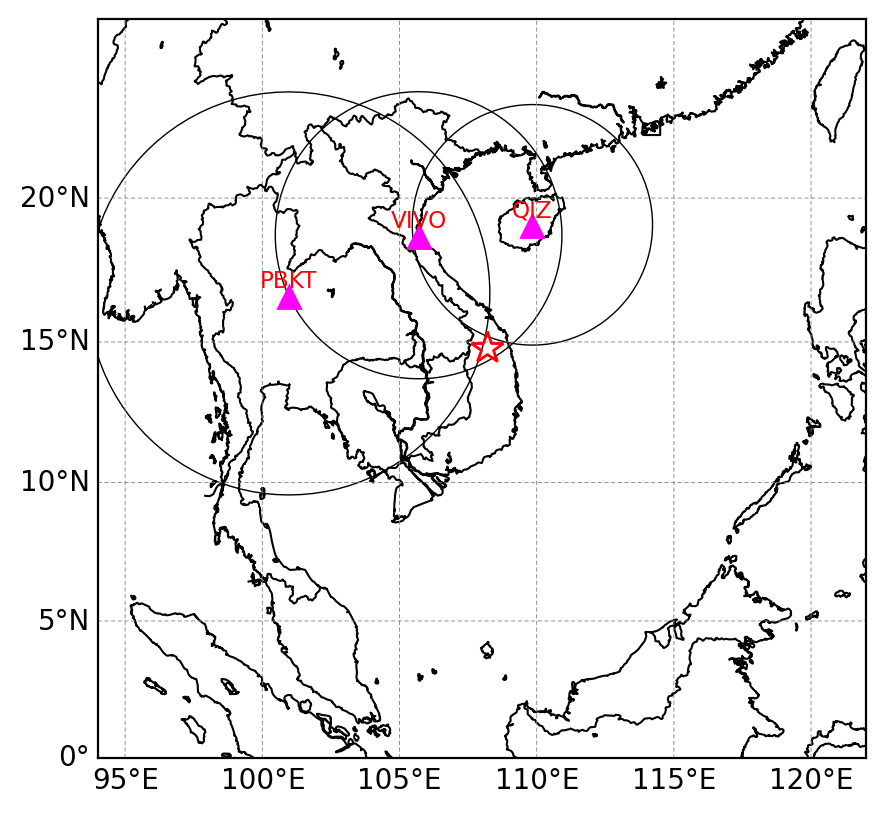

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26,
            llcrnrlon=94, urcrnrlon=122, resolution='i')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the station locations
for key, val in picks.items():
    m.plot(val['lon'], val['lat'], '^', c='magenta', markersize=8, latlon=True)
    m.tissot(val['lon'], val['lat'], val['dist']/111.1195, 100, facecolor='none', edgecolor='k', linewidth=0.5)
    x, y = m(val['lon'], val['lat'])
    ax.text(x, y+4e4, key, fontsize='small', color='r', ha='center')
    picks[key].update({'x': x, 'y': y})

# plot the epicenter
m.plot(origin_lon, origin_lat, '*', markersize=12, label='Epicenter', latlon=True, c='none', mec='r')

# show the plot
plt.show()

In [16]:
## define the objective function
def objective_function(X):
    x, y = X
    obj = 0
    for key, val in picks.items():
        obj += (np.sqrt((x - val['x'])**2 + (y - val['y'])**2) - val['dist']*1e3)**2
    return obj

## optimize the epicenter location
from scipy.optimize import minimize
X0 = m(origin_lon, origin_lat)
res = minimize(objective_function, x0=X0, method='Nelder-Mead')

print (res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5525006806.718622
             x: [ 1.578e+06  1.696e+06]
           nit: 68
          nfev: 138
 final_simplex: (array([[ 1.578e+06,  1.696e+06],
                       [ 1.578e+06,  1.696e+06],
                       [ 1.578e+06,  1.696e+06]]), array([ 5.525e+09,  5.525e+09,  5.525e+09]))


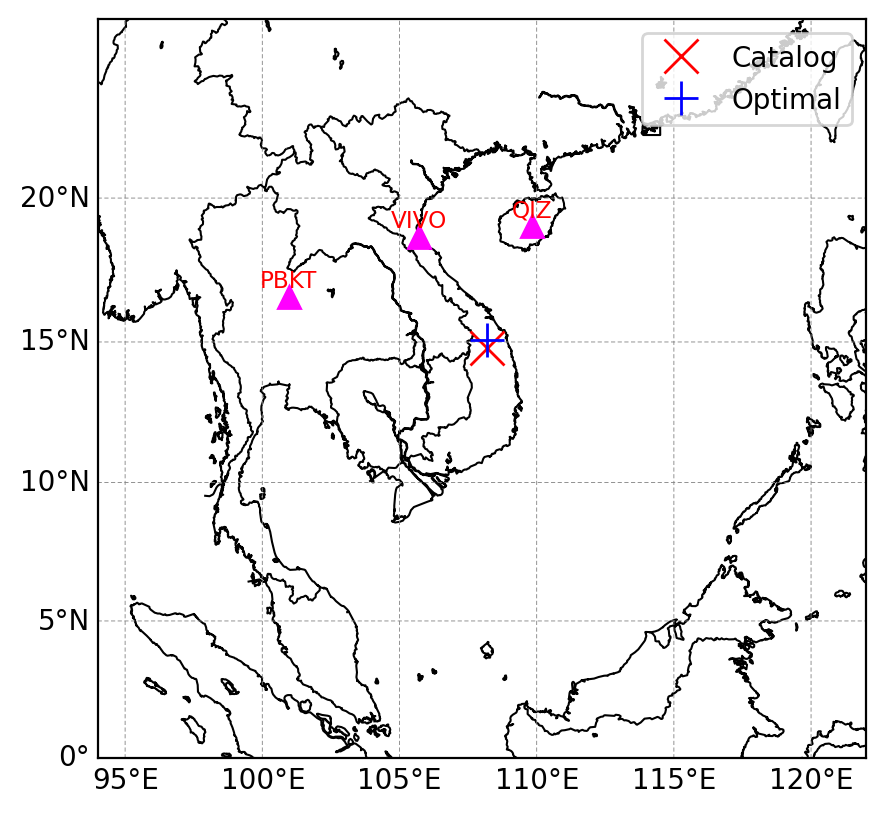

In [17]:
# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26,
            llcrnrlon=94, urcrnrlon=122, resolution='i')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the station locations
for key, val in picks.items():
    m.plot(val['x'], val['y'], '^', c='magenta', markersize=8)
    ax.text(val['x'], val['y']+4e4, key, fontsize='small', color='r', ha='center')

# plot the epicenter
m.plot(*X0, 'x', markersize=12, label='Catalog', mec='r')

# plot the epicenter
m.plot(*res.x, '+', markersize=12, label='Optimal', mec='b')

ax.legend()
# show the plot
plt.show()

In [18]:
data = np.array([UTCDateTime(_['s_arr']) - UTCDateTime(_['p_arr']) for _ in picks.values()])

def forward_prob(S):
    '''
    This forward problem returns the differential travel times of the S wave
    and P wave for a given epicenter location S observed at three stations 
    QIZ, VIVO, PBKT.
    '''
    src_lat, src_lon = S
    output = []
    for rcv in picks.values():
        p_arvs = taup_model.get_travel_times_geo(0, src_lat, src_lon, rcv['lat'], rcv['lon'], phase_list=['P'])
        s_arvs = taup_model.get_travel_times_geo(0, src_lat, src_lon, rcv['lat'], rcv['lon'], phase_list=['S'])
        output.append(s_arvs[0].time - p_arvs[0].time)
    return np.array(output)

## define the objective function
def loss_func(S):
    '''
    This function computes the log likelihood of the observed data given the
    epicenter location S.
    '''
    pred = forward_prob(S)
    return np.sum((data - pred)**2)

## optimize the epicenter location
X0 = (origin_lat, origin_lon)
res = minimize(loss_func, x0=X0, method='Nelder-Mead')
print (res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 40.8056431533417
             x: [ 1.487e+01  1.083e+02]
           nit: 32
          nfev: 64
 final_simplex: (array([[ 1.487e+01,  1.083e+02],
                       [ 1.487e+01,  1.083e+02],
                       [ 1.487e+01,  1.083e+02]]), array([ 4.081e+01,  4.081e+01,  4.081e+01]))


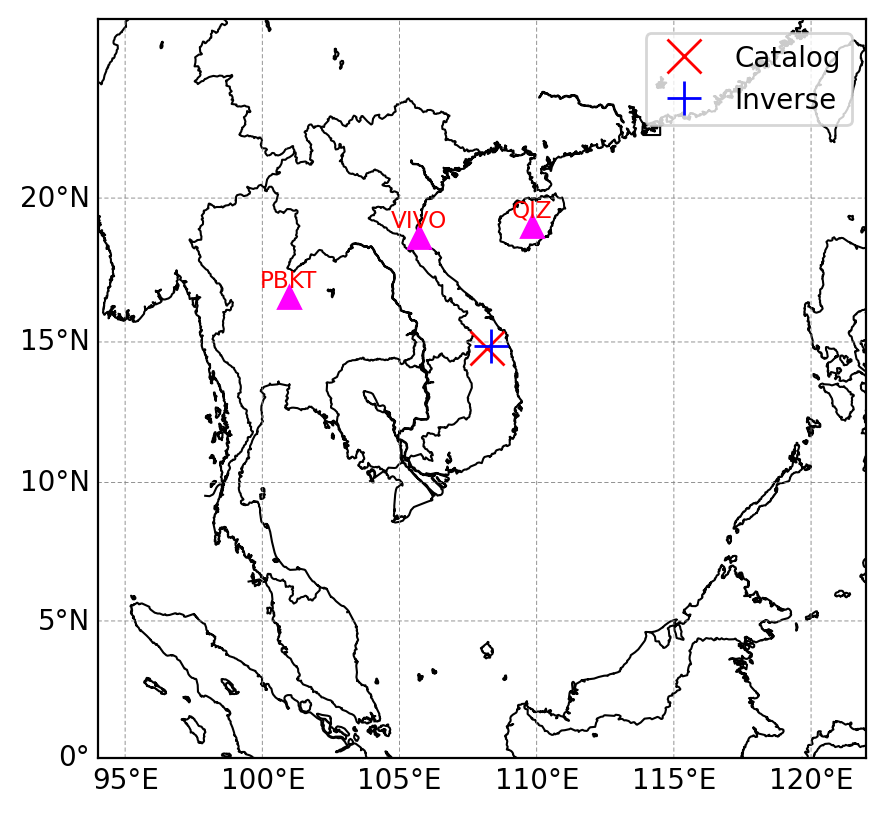

In [19]:
# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26,
            llcrnrlon=94, urcrnrlon=122, resolution='i')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the station locations
for key, val in picks.items():
    m.plot(val['x'], val['y'], '^', c='magenta', markersize=8)
    ax.text(val['x'], val['y']+4e4, key, fontsize='small', color='r', ha='center')

# plot the epicenter
m.plot(X0[1], X0[0], 'x', markersize=12, label='Catalog', mec='r', latlon=True)

# plot the epicenter
m.plot(res.x[1], res.x[0], '+', markersize=12, label='Inverse', mec='b', latlon=True)

ax.legend()
# show the plot
plt.show()

# Bayesian sampling and uncertainty estimates

In [40]:
import emcee

## define the objective function
def log_prob(S):
    '''
    This function computes the log likelihood of the observed data given the
    epicenter location S.
    '''
    if not (0 <= S[0] <= 26 and 94 <= S[1] <= 122): return -np.inf
    pred = forward_prob(S)
    sigma = np.ones_like(data) * 5
    return -.5 * np.sum((data - pred)**2 / sigma**2 + np.log(2 * np.pi * sigma**2))

## initialize the walkers
nwalkers = 6
ndim = 2
p0 = np.random.uniform(0, 1, (nwalkers, ndim))
p0[:, 0] *= 26
p0[:, 1] = 94 + p0[:, 1] * 28

## run the MCMC
nsteps = 100
from multiprocessing import Pool
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_prob, pool=pool)
    sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


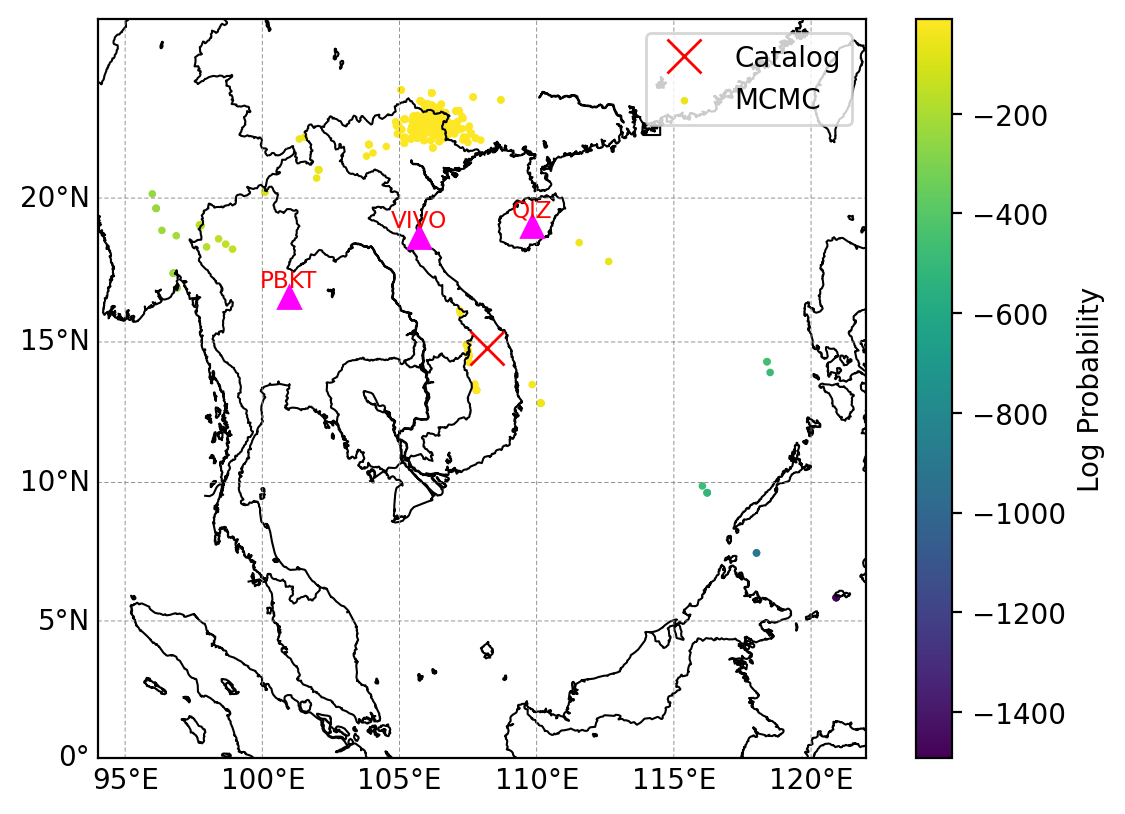

In [41]:
# create a new figure and axis
fig, ax = plt.subplots()
# initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
# the initialzed map instance is attached to the axis ax
m = Basemap(projection='merc',ax=ax, llcrnrlat=0, urcrnrlat=26,
            llcrnrlon=94, urcrnrlon=122, resolution='i')
# draw coastlines
m.drawcoastlines(linewidth=0.75)
# draw country boundaries
m.drawcountries(linewidth=0.75)
# draw parallels and meridians
m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))

# plot the station locations
for key, val in picks.items():
    m.plot(val['x'], val['y'], '^', c='magenta', markersize=8)
    ax.text(val['x'], val['y']+4e4, key, fontsize='small', color='r', ha='center')

# plot the epicenter
m.plot(X0[1], X0[0], 'x', markersize=12, label='Catalog', mec='r', latlon=True)

# plot the epicenter
sols = sampler.get_chain(flat=True)
lprob = sampler.get_log_prob(flat=True)
mappable = m.scatter(sols[:,1], sols[:,0], label='MCMC', c=lprob, latlon=True, s=3)

plt.colorbar(mappable, label='Log Probability')

ax.legend()
# show the plot
plt.show()